# <center>Supermarket products categorization</center>

## Table of content:
* [Intro](#intro)
* [Packages](#pkgs)
* [The Data](#data)
* [Train-test split & vectorization](#tfidf)
* [Training the model](#train)
* [Evaluating the model](#ev)
* [Results](#results)
* [Discussion](#discussion)

## Intro <a class="anchor" id="intro"></a>

Hi there! Thanks for checking out my project on supermarket product categorization.


The idea behind this project started off with the following: imagine you want to build an application to track grocery price changes. You managed to scrape some data from various vendors, but some of the vendors do not categorize their products on their website. This is problematic for you because you want to aggregate the data on category level to see the relative price differences between vendors.
This is a perfect example of using text classification. The aim of the project is to categorize unlabeled products. The labeled products were scraped from a vendor that categorizes their offers. The business implication is that labeling all products enables further analysis and deployment of business intelligence techniques.

Please note that for this project the data was gathered from vendors operating in Hungary, therefore, all product names and categories are in Hungarian.

## Packages <a class="anchor" id="pkgs"></a>

Let me first introduce the main packages and functions I use for this project.\
First, I use pandas for data manipulation. Next, I use numpy to set pandas series objects into arrays. Then, I use sklearn to vectorize the data based on TF-IDF method. Afterwards I use sklearn for each of the models that I train. Moreover, to get a list of Hungarian stopwords, I used the NLTK package and for visualization matplotplib + seaborn.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

## The Data <a class="anchor" id="data"></a>

The data was collected from two vendors: [Auchan](https://online.auchan.hu/) for the labeled products and [Aldi](https://www.aldi.hu/) for unlabeled products.\
Let's first read in the training data with the labeled products.

In [2]:
train = pd.read_csv('./data/train.csv')
train.head()

,product,category
0,Tuti Tipp Zabpehely 250 g,Tartós élelmiszerek
1,"Bebe Gently Rosé ajakbalzsam 4,9 g",Szépségápolás
2,Kinder Tejszelet tejes krémmel töltött sütemén...,Tejtermék
3,Auchan Optimum Kozmetikai vattakorong 100 db n...,Szépségápolás
4,"Zlatý Bažant világos dobozos sör 4,6% 0,5 l",Alkohol


First, it is important to check for missing values. In our case, there is only 1 missing value so we can just remove that from the dataset.

In [7]:
train.isnull().sum()

product     1
category    0
dtype: int64

In [8]:
train.dropna(inplace = True)

There are a total of 13 unique categories in this dataset.

In [9]:
train['category'].nunique()

13

The most prominent one is the category of durable foods, which should e.g. contain canned goods.\
The category with the least amount of observations is the baked goods.\
We can also observe that the data is unbalanced and we need to deal with this issue later on when splitting the data to training and testing & when selecting the evaluation metric.

In [10]:
train['category'].value_counts()

Tartós élelmiszerek                5771
Szépségápolás                      5561
Alkohol                            3398
Italok                             2694
Egészséges életmód                 2612
Tejtermék                          2393
Édesség, csokoládé, nasi           2380
Hús, hal, felvágott                2213
Háztartási-, vegyi- és papíráru    1842
Fagyasztott élelmiszer             1262
Zöldség, gyümölcs                   849
Háztartás                           692
Pékáru                              689
Name: category, dtype: int64

## Train-test split & vectorization <a class="anchor" id="tfidf"></a>

In order to test the model performance, I split the data so that there is about 20% remaining for testing. Since the dataset is unbalanced, it is important to stratify the random split to make sure that each category is proportinally represented in both the training and the test set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train['product'], train['category'], test_size=.2, 
                                                random_state=424242, stratify = train['category'], shuffle = True)

To create the Bag-of-words for the model, I use the TF-IDF method, that inversely relates term frequency in a given document with the frequency of that term in all documents. What this means is that those words that appear frequently in one document but do not appear frequently in other documents will get a higher weight as these terms are considered as defining the given observation.\
Moreover, I decided to remove the so called stopwords in the hungarian language. These are words that are so frequently used that they don't bring added value as a feature in the BOW. Stopwords are such as 'the' or 'a' in the English language.

In [12]:
# Instantiate the TfidfVectorizer method
hun_stopwords = stopwords.words('hungarian')
tfidf_transformer = TfidfVectorizer(stop_words = hun_stopwords)

In [13]:
# Fit the training data and then transform the test data
training_data = tfidf_transformer.fit_transform(X_train)
testing_data = tfidf_transformer.transform(X_test)
print('The number of words in our bag:', len(tfidf_transformer.get_feature_names()))

The number of words in our bag: 15049


## Training the model <a class="anchor" id="train"></a>

I decided to use multiple models first to see which algorithm performs best on our data.
My hunch is that since we are working with a sparse matrix with 15049 individual features, those models that apply some regularization such as the l2 or l1 norm should fit the data the best. Therefore, I use the RidgeClassifier.\
Furthermore, I added some well known algorithms to cover a wide variety of different methods. For example, I added the K-nearest neighbors classifier, which is the simplest model from my range.\
It is often beneficial to include simple models as baselines because if the difference between the models is marginal, then the simplest model should be selected according to the principle of Occam's razer.

For my baseline I do not tune the hyperparameters as I am just interested in the best performing model without tuning. Based on the preliminary results we can confirm my hunch that regularized models perform better. As we can see, the Ridge classifier had the second best performance measured in balanced accuracy. The best performance, however, was achieved with the linear SVM classifer so I selected this model for hyperparameter tuning.

In [14]:
def baseline(clf):
    print("_" * 40)
    print("Training: ")
    print(clf)
    clf.fit(training_data, y_train)
    pred = clf.predict(testing_data)

    score = balanced_accuracy_score(y_test, pred)
    print("Balanced Accuracy: %0.3f" % score,'\n')

for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
    (AdaBoostClassifier(n_estimators=500), "Adaboost"),
    (GradientBoostingClassifier(n_estimators=500), "Gradient Boosting"),
    (LinearSVC(), "Linear SVC"),
    (SGDClassifier(), "Stochastic Gradient Descent")
):
    print("=" * 40)
    print(name)
    baseline(clf)

Ridge Classifier
________________________________________
Training: 
RidgeClassifier(tol=0.01)
Balanced Accuracy: 0.879 

Perceptron
________________________________________
Training: 
Perceptron(max_iter=50)
Balanced Accuracy: 0.874 

kNN
________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
Balanced Accuracy: 0.834 

Random forest
________________________________________
Training: 
RandomForestClassifier()
Balanced Accuracy: 0.840 

Adaboost
________________________________________
Training: 
AdaBoostClassifier(n_estimators=500)
Balanced Accuracy: 0.439 

Gradient Boosting
________________________________________
Training: 
GradientBoostingClassifier(n_estimators=500)
Balanced Accuracy: 0.838 

Linear SVC
________________________________________
Training: 
LinearSVC()
Balanced Accuracy: 0.897 

Stochastic Gradient Descent
________________________________________
Training: 
SGDClassifier()
Balanced Accuracy: 0.860 



To tune the hyperparameters, I decided to keep the l2 norm as the penalty term for the model so that regularization is applied. I also make use of gridsearching for the best hyperparameters, with special regard to the regularization parameter (C) and the tolerance for the stopping criteria (tol).\
I make sure that my model is not overfitting by using 10-fold stratified cross-validation. Again, stratifying here is used to make sure that each fold is representative to all categories. Since the data is unbalanced, the evaluation metric I use is the balanced accuracy, which is the arithmetic mean of sensitivity and specificity.

In [15]:
# Initialize the classifier
clf = LinearSVC(random_state=10042, max_iter=5000)
params = {'penalty': ['l2'],
          'C' : [x for x in np.linspace(start = 1, stop = 5, num = 25)],
          'tol': [x for x in np.linspace(start = 1e-4, stop = 1e-2, num = 25)]
         }

# Make an fbeta_score scoring object using make_scorer()
# scorer = make_scorer(fbeta_score, beta=0.5, average='weighted')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
# balance the dataset for validation with stratified shuffle split
cv = StratifiedKFold(n_splits=10, random_state=645845142, shuffle=True)
grid_obj = GridSearchCV(clf, params, scoring='balanced_accuracy', cv=cv, verbose=2)

grid_fit = grid_obj.fit(training_data, y_train)

Fitting 10 folds for each of 625 candidates, totalling 6250 fits
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.2s
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.2s
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.2s
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.2s
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.2s
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.2s
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END ......................C=1.0, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END ...................C=1.0, penalty=l2, tol=0.0005125; total time=   0.2s
[CV] END ...................C=1.0, penalty=l

[CV] END .......C=1.0, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END .......C=1.0, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END .......C=1.0, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END .......C=1.0, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END .......C=1.0, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END .......C=1.0, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END .......C=1.0, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END .......C=1.0, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END .......C=1.0, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END ........C=1.0, penalty=l2, tol=0.004637500000000001; total time=   0.2s
[CV] END ........C=1.0, penalty=l2, tol=0.004637500000000001; total time=   0.2s
[CV] END ........C=1.0, penalty=l2, tol=0.004637500000000001; total time=   0.2s
[CV] END ........C=1.0, pena

[CV] END .....................C=1.0, penalty=l2, tol=0.00835; total time=   0.2s
[CV] END .....................C=1.0, penalty=l2, tol=0.00835; total time=   0.2s
[CV] END .....................C=1.0, penalty=l2, tol=0.00835; total time=   0.2s
[CV] END .....................C=1.0, penalty=l2, tol=0.00835; total time=   0.2s
[CV] END .....................C=1.0, penalty=l2, tol=0.00835; total time=   0.2s
[CV] END .....................C=1.0, penalty=l2, tol=0.00835; total time=   0.2s
[CV] END .....................C=1.0, penalty=l2, tol=0.00835; total time=   0.2s
[CV] END ........C=1.0, penalty=l2, tol=0.008762500000000001; total time=   0.2s
[CV] END ........C=1.0, penalty=l2, tol=0.008762500000000001; total time=   0.2s
[CV] END ........C=1.0, penalty=l2, tol=0.008762500000000001; total time=   0.2s
[CV] END ........C=1.0, penalty=l2, tol=0.008762500000000001; total time=   0.2s
[CV] END ........C=1.0, penalty=l2, tol=0.008762500000000001; total time=   0.2s
[CV] END ........C=1.0, pena

[CV] END ....C=1.1666666666666667, penalty=l2, tol=0.0021625; total time=   0.3s
[CV] END ....C=1.1666666666666667, penalty=l2, tol=0.0021625; total time=   0.2s
[CV] END ....C=1.1666666666666667, penalty=l2, tol=0.0021625; total time=   0.2s
[CV] END ....C=1.1666666666666667, penalty=l2, tol=0.0021625; total time=   0.2s
[CV] END ....C=1.1666666666666667, penalty=l2, tol=0.0021625; total time=   0.3s
[CV] END ....C=1.1666666666666667, penalty=l2, tol=0.0021625; total time=   0.3s
[CV] END ....C=1.1666666666666667, penalty=l2, tol=0.0021625; total time=   0.3s
[CV] END ....C=1.1666666666666667, penalty=l2, tol=0.0021625; total time=   0.3s
[CV] END .....C=1.1666666666666667, penalty=l2, tol=0.002575; total time=   0.2s
[CV] END .....C=1.1666666666666667, penalty=l2, tol=0.002575; total time=   0.3s
[CV] END .....C=1.1666666666666667, penalty=l2, tol=0.002575; total time=   0.3s
[CV] END .....C=1.1666666666666667, penalty=l2, tol=0.002575; total time=   0.2s
[CV] END .....C=1.1666666666

[CV] END C=1.1666666666666667, penalty=l2, tol=0.005875000000000001; total time=   0.3s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.005875000000000001; total time=   0.2s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.005875000000000001; total time=   0.2s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.006287500000000001; total time=   0.2s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.006287500000000001; total time=   0.2s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.006287500000000001; total time=   0.2s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.006287500000000001; total time=   0.2s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.006287500000000001; total time=   0.2s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.006287500000000001; total time=   0.2s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.006287500000000001; total time=   0.3s
[CV] END C=1.1666666666666667, penalty=l2, tol=0.006287500000000001; total time=   0.2s
[CV] END C=1.1666666666666667, p

[CV] END .........C=1.1666666666666667, penalty=l2, tol=0.01; total time=   0.2s
[CV] END .........C=1.1666666666666667, penalty=l2, tol=0.01; total time=   0.2s
[CV] END .........C=1.1666666666666667, penalty=l2, tol=0.01; total time=   0.2s
[CV] END .........C=1.1666666666666667, penalty=l2, tol=0.01; total time=   0.2s
[CV] END .........C=1.1666666666666667, penalty=l2, tol=0.01; total time=   0.2s
[CV] END .........C=1.1666666666666667, penalty=l2, tol=0.01; total time=   0.2s
[CV] END .......C=1.3333333333333333, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END .......C=1.3333333333333333, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END .......C=1.3333333333333333, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END .......C=1.3333333333333333, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END .......C=1.3333333333333333, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END .......C=1.3333333333333333, penalty=l2, tol=0.0001; total time=   0.3s
[CV] END .......C=1.33333333

[CV] END C=1.3333333333333333, penalty=l2, tol=0.0038125000000000004; total time=   0.3s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0038125000000000004; total time=   0.3s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0038125000000000004; total time=   0.5s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0038125000000000004; total time=   0.3s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0038125000000000004; total time=   0.2s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0038125000000000004; total time=   0.2s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0038125000000000004; total time=   0.2s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0038125000000000004; total time=   0.2s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.2s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.3s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.3s
[CV] END C=1.33333333

[CV] END C=1.3333333333333333, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END C=1.3333333333333333, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END ....C=1.3333333333333333, penalty=l2, tol=0.0079375; total time=   0.2s
[CV] END ....C=1.3333333333333333, penalty=l2, tol=0.0079375; total time=   0.3s
[CV] END ....C=1.3333333333333333, penalty=l2, tol=0.0079375; total time=   0.2s
[CV] END ....C=1.3333333333333333, penalty=l2, tol=0.0079375; total time=   0.2s
[CV] END ....C=1.3333333333333333, penalty=l2, tol=0.0079375; total time=   0.2s
[CV] END ....C=1.3333333333333333, penalty=l2, tol=0.0079375; total time=   0.2s
[CV] END ....C=1.3333333333333333, penalty=l2, tol=0.0079375; total time= 

[CV] END .......C=1.5, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0017500000000000003; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0017500000000000003; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0017500000000000003; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0017500000000000003; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0017500000000000003; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0017500000000000003; total time=   0.3s
[CV] END .......C=1.5, penalty=l2, tol=0.0017500000000000003; total time=   0.3s
[CV] END .......C=1.5, penal

[CV] END ........C=1.5, penalty=l2, tol=0.005462500000000001; total time=   0.5s
[CV] END ........C=1.5, penalty=l2, tol=0.005462500000000001; total time=   0.3s
[CV] END ........C=1.5, penalty=l2, tol=0.005462500000000001; total time=   0.2s
[CV] END ........C=1.5, penalty=l2, tol=0.005875000000000001; total time=   0.2s
[CV] END ........C=1.5, penalty=l2, tol=0.005875000000000001; total time=   0.2s
[CV] END ........C=1.5, penalty=l2, tol=0.005875000000000001; total time=   0.2s
[CV] END ........C=1.5, penalty=l2, tol=0.005875000000000001; total time=   0.2s
[CV] END ........C=1.5, penalty=l2, tol=0.005875000000000001; total time=   0.2s
[CV] END ........C=1.5, penalty=l2, tol=0.005875000000000001; total time=   0.3s
[CV] END ........C=1.5, penalty=l2, tol=0.005875000000000001; total time=   0.3s
[CV] END ........C=1.5, penalty=l2, tol=0.005875000000000001; total time=   0.3s
[CV] END ........C=1.5, penalty=l2, tol=0.005875000000000001; total time=   0.3s
[CV] END ........C=1.5, pena

[CV] END ...................C=1.5, penalty=l2, tol=0.0095875; total time=   0.2s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.2s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.2s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.2s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.2s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.2s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.2s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.2s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.2s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.3s
[CV] END ........................C=1.5, penalty=l2, tol=0.01; total time=   0.2s
[CV] END .......C=1.6666666666666665, penalty=l2, tol=0.0001; total time=   0.5s
[CV] END .......C=1.66666666

[CV] END C=1.6666666666666665, penalty=l2, tol=0.0034000000000000002; total time=   0.4s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0034000000000000002; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0034000000000000002; total time=   0.2s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.2s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.2s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.2s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.2s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.3s
[CV] END C=1.66666666

[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.3s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END C=1.6666666666666665, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END ....C=1.6666666666666665, penalty=l2, tol=0.0079375; total time=   0.2s
[CV] END ....C=1.6666666666666665, pena

[CV] END C=1.8333333333333333, penalty=l2, tol=0.0009250000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.2s
[CV] END C=1.83333333

[CV] END C=1.8333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.2s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.2s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.3s
[CV] END C=1.8333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.3s
[CV] END C=1.8333333333333333, p

[CV] END C=1.8333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.2s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.2s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.2s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=1.8333333333333333, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END ....C=1.8333333333333333, penalty=l2, tol=0.0095875; total time=   0.3s
[CV] END ....C=1.8333

[CV] END ...................C=2.0, penalty=l2, tol=0.0029875; total time=   0.3s
[CV] END ...................C=2.0, penalty=l2, tol=0.0029875; total time=   0.3s
[CV] END ...................C=2.0, penalty=l2, tol=0.0029875; total time=   0.4s
[CV] END ...................C=2.0, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END ...................C=2.0, penalty=l2, tol=0.0029875; total time=   0.6s
[CV] END ...................C=2.0, penalty=l2, tol=0.0029875; total time=   0.4s
[CV] END ...................C=2.0, penalty=l2, tol=0.0029875; total time=   0.3s
[CV] END ...................C=2.0, penalty=l2, tol=0.0029875; total time=   0.3s
[CV] END ...................C=2.0, penalty=l2, tol=0.0029875; total time=   0.3s
[CV] END .......C=2.0, penalty=l2, tol=0.0034000000000000002; total time=   0.3s
[CV] END .......C=2.0, penalty=l2, tol=0.0034000000000000002; total time=   0.3s
[CV] END .......C=2.0, penalty=l2, tol=0.0034000000000000002; total time=   0.3s
[CV] END .......C=2.0, penal

[CV] END ........C=2.0, penalty=l2, tol=0.007112500000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007112500000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007112500000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007112500000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007112500000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007112500000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007112500000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007525000000000001; total time=   0.2s
[CV] END ........C=2.0, penalty=l2, tol=0.007525000000000001; total time=   0.3s
[CV] END ........C=2.0, penalty=l2, tol=0.007525000000000001; total time=   0.3s
[CV] END ........C=2.0, pena

[CV] END C=2.1666666666666665, penalty=l2, tol=0.0009250000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0009250000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0009250000000000001; total time=   0.4s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0009250000000000001; total time=   0.4s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0009250000000000001; total time=   0.4s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0009250000000000001; total time=   0.4s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0013375000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0013375000000000001; total time=   0.4s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0013375000000000001; total time=   0.4s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0013375000000000001; total time=   0.4s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.0013375000000000001; total time=   0.4s
[CV] END C=2.16666666

[CV] END C=2.1666666666666665, penalty=l2, tol=0.004637500000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END C=2.1666666666666665, p

[CV] END C=2.1666666666666665, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.008762500000000001; total time=   0.2s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END C=2.1666666666666665, penalty=l2, tol=0.008762500000000001; total time=   0.4s
[CV] END .....C=2.1666666666666665, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=2.1666666666666665, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=2.1666666666666665, penalty=l2, tol=0.009175; total time=   0.4s
[CV] END .....C=2.1666666666666665, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=2.1666666666666665, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END .....C=2.1666666666666665, penalty=l2, tol=0.009175; total

[CV] END ......C=2.333333333333333, penalty=l2, tol=0.002575; total time=   0.6s
[CV] END ......C=2.333333333333333, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ......C=2.333333333333333, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ......C=2.333333333333333, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END ......C=2.333333333333333, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END ......C=2.333333333333333, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END ......C=2.333333333333333, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.333333333333333, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END .....C=2.333333333333333, penalty=l2, tol=0.0029875; total time=   0.4s
[CV] END .....C=2.333333333333333, penalty=l2, tol=0.0029875; total time=   0.4s
[CV] END .....C=2.333333333333333, penalty=l2, tol=0.0029875; total time=   0.4s
[CV] END .....C=2.333333333333333, penalty=l2, tol=0.0029875; total time=   0.3s
[CV] END .....C=2.3333333333

[CV] END C=2.333333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.6s
[CV] END C=2.333333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.3s
[CV] END C=2.333333333333333, penalty=l2, t

[CV] END ......................C=2.5, penalty=l2, tol=0.0001; total time=   0.5s
[CV] END ......................C=2.5, penalty=l2, tol=0.0001; total time=   0.5s
[CV] END ......................C=2.5, penalty=l2, tol=0.0001; total time=   0.5s
[CV] END ...................C=2.5, penalty=l2, tol=0.0005125; total time=   0.4s
[CV] END ...................C=2.5, penalty=l2, tol=0.0005125; total time=   0.5s
[CV] END ...................C=2.5, penalty=l2, tol=0.0005125; total time=   0.4s
[CV] END ...................C=2.5, penalty=l2, tol=0.0005125; total time=   0.4s
[CV] END ...................C=2.5, penalty=l2, tol=0.0005125; total time=   0.5s
[CV] END ...................C=2.5, penalty=l2, tol=0.0005125; total time=   0.4s
[CV] END ...................C=2.5, penalty=l2, tol=0.0005125; total time=   0.4s
[CV] END ...................C=2.5, penalty=l2, tol=0.0005125; total time=   0.4s
[CV] END ...................C=2.5, penalty=l2, tol=0.0005125; total time=   0.4s
[CV] END ...................

[CV] END .......C=2.5, penalty=l2, tol=0.0042250000000000005; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.004637500000000001; total time=   0.3s
[CV] END ........C=2.5, penalty=l2, tol=0.005050000000000001; total time=   0.3s
[CV] END ........C=2.5, pena

[CV] END ........C=2.5, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END ........C=2.5, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END ........C=2.5, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END ........C=2.5, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END ........C=2.5, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END ........C=2.5, penalty=l2, tol=0.008762500000000001; total time=   0.4s
[CV] END ........C=2.5, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END ........C=2.5, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END ........C=2.5, penalty=l2, tol=0.008762500000000001; total time=   0.3s
[CV] END ....................C=2.5, penalty=l2, tol=0.009175; total time=   0.3s
[CV] END ....................C=2.5, penalty=l2, tol=0.009175; total time=   0.4s
[CV] END ....................C=2.5, penalty=l2, tol=0.009175; total time=   0.4s
[CV] END ...................

[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END .....C=2.6666666666666665, penalty=l2, tol=0.002575; total time=   0.4s
[CV] END ....C=2.6666666666666665, penalty=l2, tol=0.0029875; total time=   0.4s
[CV] END ....C=2.6666666666666665, penalty=l2, tol=0.0029875; total time=   0.4s
[CV] END ....C=2.66666666666

[CV] END C=2.6666666666666665, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006700000000000001; total time=   0.3s
[CV] END C=2.6666666666666665, penalty=l2, tol=0.006700000000000001; total time=   0.3s
[CV] END C=2.6666666666666665, p

[CV] END ........C=2.833333333333333, penalty=l2, tol=0.0001; total time=   0.4s
[CV] END ........C=2.833333333333333, penalty=l2, tol=0.0001; total time=   0.5s
[CV] END ........C=2.833333333333333, penalty=l2, tol=0.0001; total time=   0.5s
[CV] END ........C=2.833333333333333, penalty=l2, tol=0.0001; total time=   0.6s
[CV] END ........C=2.833333333333333, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END ........C=2.833333333333333, penalty=l2, tol=0.0001; total time=   0.6s
[CV] END ........C=2.833333333333333, penalty=l2, tol=0.0001; total time=   0.5s
[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0005125; total time=   0.5s
[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0005125; total time=   0.5s
[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0005125; total time=   0.4s
[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0005125; total time=   0.5s
[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0005125; total time=   0.5s
[CV] END .....C=2.8333333333

[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.4s
[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.4s
[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.3s
[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.3s
[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.3s
[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.3s
[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.4s
[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.4s
[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.4s
[CV] END C=2.833333333333333, penalty=l2, tol=0.0042250000000000005; total time=   0.4s
[CV] END C=2.833333333333333, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END C=2.833333333333333, pen

[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0079375; total time=   0.3s
[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0079375; total time=   0.3s
[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0079375; total time=   0.3s
[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0079375; total time=   0.4s
[CV] END .....C=2.833333333333333, penalty=l2, tol=0.0079375; total time=   0.3s
[CV] END .......C=2.833333333333333, penalty=l2, tol=0.00835; total time=   0.3s
[CV] END .......C=2.833333333333333, penalty=l2, tol=0.00835; total time=   0.3s
[CV] END .......C=2.833333333333333, penalty=l2, tol=0.00835; total time=   0.3s
[CV] END .......C=2.833333333333333, penalty=l2, tol=0.00835; total time=   0.3s
[CV] END .......C=2.833333333333333, penalty=l2, tol=0.00835; total time=   0.3s
[CV] END .......C=2.833333333333333, penalty=l2, tol=0.00835; total time=   0.3s
[CV] END .......C=2.833333333333333, penalty=l2, tol=0.00835; total time=   0.3s
[CV] END .......C=2.83333333

[CV] END .......C=3.0, penalty=l2, tol=0.0017500000000000003; total time=   0.6s
[CV] END .......C=3.0, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END .......C=3.0, penalty=l2, tol=0.0017500000000000003; total time=   0.4s
[CV] END .......C=3.0, penalty=l2, tol=0.0017500000000000003; total time=   0.4s
[CV] END ...................C=3.0, penalty=l2, tol=0.0021625; total time=   0.4s
[CV] END ...................C=3.0, penalty=l2, tol=0.0021625; total time=   0.4s
[CV] END ...................C=3.0, penalty=l2, tol=0.0021625; total time=   0.4s
[CV] END ...................C=3.0, penalty=l2, tol=0.0021625; total time=   0.3s
[CV] END ...................C=3.0, penalty=l2, tol=0.0021625; total time=   0.4s
[CV] END ...................C=3.0, penalty=l2, tol=0.0021625; total time=   0.4s
[CV] END ...................C=3.0, penalty=l2, tol=0.0021625; total time=   0.5s
[CV] END ...................C=3.0, penalty=l2, tol=0.0021625; total time=   0.8s
[CV] END ...................

[CV] END ........C=3.0, penalty=l2, tol=0.005875000000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.005875000000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.3s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.4s
[CV] END ........C=3.0, penalty=l2, tol=0.006287500000000001; total time=   0.5s
[CV] END ........C=3.0, pena

[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.6s
[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.6s
[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.6s
[CV] END .......C=3.1666666666666665, penalty=l2, tol=0.0001; total time=   0.5s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0005125; total time=   0.4s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0005125; total time=   0.5s
[CV] END ....C=3.16666666666

[CV] END C=3.1666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.4s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.4s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0038125000000000004; total time=   0.4s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0042250000000000005; total time=   0.4s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0042250000000000005; total time=   0.6s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0042250000000000005; total time=   0.6s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0042250000000000005; total time=   0.6s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0042250000000000005; total time=   0.4s
[CV] END C=3.1666666666666665, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END C=3.16666666

[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.4s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.4s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.5s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.4s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.4s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.4s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.3s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.4s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.4s
[CV] END ....C=3.1666666666666665, penalty=l2, tol=0.0079375; total time=   0.4s
[CV] END ......C=3.1666666666666665, penalty=l2, tol=0.00835; total time=   0.4s
[CV] END ......C=3.1666666666666665, penalty=l2, tol=0.00835; total time=   0.4s
[CV] END ......C=3.166666666

[CV] END C=3.333333333333333, penalty=l2, tol=0.0013375000000000001; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.4s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.4s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.4s
[CV] END C=3.333333333333333, penalty=l2, tol=0.0017500000000000003; total time=   0.4s
[CV] END .....C=3.33333333333333

[CV] END C=3.333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.4s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.4s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.4s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005462500000000001; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005875000000000001; total time=   0.3s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005875000000000001; total time=   0.3s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005875000000000001; total time=   0.3s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005875000000000001; total time=   0.4s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005875000000000001; total time=   0.4s
[CV] END C=3.333333333333333, penalty=l2, tol=0.005875000000000001; total time=   0.5s
[CV] END C=3.333333333333333, penalty=l2, t

[CV] END .....C=3.333333333333333, penalty=l2, tol=0.0095875; total time=   0.4s
[CV] END .....C=3.333333333333333, penalty=l2, tol=0.0095875; total time=   0.4s
[CV] END .....C=3.333333333333333, penalty=l2, tol=0.0095875; total time=   0.3s
[CV] END .....C=3.333333333333333, penalty=l2, tol=0.0095875; total time=   0.4s
[CV] END .....C=3.333333333333333, penalty=l2, tol=0.0095875; total time=   0.4s
[CV] END .....C=3.333333333333333, penalty=l2, tol=0.0095875; total time=   0.4s
[CV] END .....C=3.333333333333333, penalty=l2, tol=0.0095875; total time=   0.4s
[CV] END .....C=3.333333333333333, penalty=l2, tol=0.0095875; total time=   0.4s
[CV] END ..........C=3.333333333333333, penalty=l2, tol=0.01; total time=   0.4s
[CV] END ..........C=3.333333333333333, penalty=l2, tol=0.01; total time=   0.4s
[CV] END ..........C=3.333333333333333, penalty=l2, tol=0.01; total time=   0.4s
[CV] END ..........C=3.333333333333333, penalty=l2, tol=0.01; total time=   0.4s
[CV] END ..........C=3.33333

[CV] END .......C=3.5, penalty=l2, tol=0.0034000000000000002; total time=   0.5s
[CV] END .......C=3.5, penalty=l2, tol=0.0034000000000000002; total time=   0.5s
[CV] END .......C=3.5, penalty=l2, tol=0.0034000000000000002; total time=   0.5s
[CV] END .......C=3.5, penalty=l2, tol=0.0034000000000000002; total time=   0.5s
[CV] END .......C=3.5, penalty=l2, tol=0.0034000000000000002; total time=   0.5s
[CV] END .......C=3.5, penalty=l2, tol=0.0034000000000000002; total time=   0.4s
[CV] END .......C=3.5, penalty=l2, tol=0.0038125000000000004; total time=   0.5s
[CV] END .......C=3.5, penalty=l2, tol=0.0038125000000000004; total time=   0.5s
[CV] END .......C=3.5, penalty=l2, tol=0.0038125000000000004; total time=   0.5s
[CV] END .......C=3.5, penalty=l2, tol=0.0038125000000000004; total time=   0.5s
[CV] END .......C=3.5, penalty=l2, tol=0.0038125000000000004; total time=   0.6s
[CV] END .......C=3.5, penalty=l2, tol=0.0038125000000000004; total time=   0.5s
[CV] END .......C=3.5, penal

[CV] END ........C=3.5, penalty=l2, tol=0.007525000000000001; total time=   0.5s
[CV] END ........C=3.5, penalty=l2, tol=0.007525000000000001; total time=   0.5s
[CV] END ........C=3.5, penalty=l2, tol=0.007525000000000001; total time=   0.6s
[CV] END ........C=3.5, penalty=l2, tol=0.007525000000000001; total time=   0.4s
[CV] END ...................C=3.5, penalty=l2, tol=0.0079375; total time=   0.5s
[CV] END ...................C=3.5, penalty=l2, tol=0.0079375; total time=   0.5s
[CV] END ...................C=3.5, penalty=l2, tol=0.0079375; total time=   0.5s
[CV] END ...................C=3.5, penalty=l2, tol=0.0079375; total time=   0.6s
[CV] END ...................C=3.5, penalty=l2, tol=0.0079375; total time=   0.5s
[CV] END ...................C=3.5, penalty=l2, tol=0.0079375; total time=   0.6s
[CV] END ...................C=3.5, penalty=l2, tol=0.0079375; total time=   0.5s
[CV] END ...................C=3.5, penalty=l2, tol=0.0079375; total time=   0.5s
[CV] END ...................

[CV] END C=3.6666666666666665, penalty=l2, tol=0.0013375000000000001; total time=   0.5s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0013375000000000001; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0013375000000000001; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0013375000000000001; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0017500000000000003; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0017500000000000003; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0017500000000000003; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.0017500000000000003; total time=   0.5s
[CV] END C=3.66666666

[CV] END C=3.6666666666666665, penalty=l2, tol=0.005462500000000001; total time=   0.5s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005462500000000001; total time=   0.4s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005462500000000001; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005462500000000001; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005462500000000001; total time=   1.4s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005462500000000001; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005462500000000001; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005462500000000001; total time=   0.5s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005462500000000001; total time=   0.6s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005875000000000001; total time=   0.5s
[CV] END C=3.6666666666666665, penalty=l2, tol=0.005875000000000001; total time=   0.5s
[CV] END C=3.6666666666666665, p

[CV] END .....C=3.6666666666666665, penalty=l2, tol=0.009175; total time=   0.7s
[CV] END .....C=3.6666666666666665, penalty=l2, tol=0.009175; total time=   0.5s
[CV] END .....C=3.6666666666666665, penalty=l2, tol=0.009175; total time=   0.6s
[CV] END ....C=3.6666666666666665, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ....C=3.6666666666666665, penalty=l2, tol=0.0095875; total time=   0.6s
[CV] END ....C=3.6666666666666665, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ....C=3.6666666666666665, penalty=l2, tol=0.0095875; total time=   0.6s
[CV] END ....C=3.6666666666666665, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ....C=3.6666666666666665, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ....C=3.6666666666666665, penalty=l2, tol=0.0095875; total time=   0.7s
[CV] END ....C=3.6666666666666665, penalty=l2, tol=0.0095875; total time=   0.6s
[CV] END ....C=3.6666666666666665, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ....C=3.66666666666

[CV] END .....C=3.833333333333333, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END .....C=3.833333333333333, penalty=l2, tol=0.0029875; total time=   0.6s
[CV] END .....C=3.833333333333333, penalty=l2, tol=0.0029875; total time=   0.7s
[CV] END .....C=3.833333333333333, penalty=l2, tol=0.0029875; total time=   0.7s
[CV] END C=3.833333333333333, penalty=l2, tol=0.0034000000000000002; total time=   0.6s
[CV] END C=3.833333333333333, penalty=l2, tol=0.0034000000000000002; total time=   0.5s
[CV] END C=3.833333333333333, penalty=l2, tol=0.0034000000000000002; total time=   0.5s
[CV] END C=3.833333333333333, penalty=l2, tol=0.0034000000000000002; total time=   0.6s
[CV] END C=3.833333333333333, penalty=l2, tol=0.0034000000000000002; total time=   0.6s
[CV] END C=3.833333333333333, penalty=l2, tol=0.0034000000000000002; total time=   0.7s
[CV] END C=3.833333333333333, penalty=l2, tol=0.0034000000000000002; total time=   0.7s
[CV] END C=3.833333333333333, penalty=l2, tol=0.003400000000

[CV] END C=3.833333333333333, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007112500000000001; total time=   0.4s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007112500000000001; total time=   0.4s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007525000000000001; total time=   0.4s
[CV] END C=3.833333333333333, penalty=l2, tol=0.007525000000000001; total time=   0.4s
[CV] END C=3.833333333333333, penalty=l2, t

[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.5s
[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.5s
[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.7s
[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.8s
[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END .......C=4.0, penalty=l2, tol=0.0009250000000000001; total time=   0.5s
[CV] END .......C=4.0, penalty=l2, tol=0.0013375000000000001; total time=   0.4s
[CV] END .......C=4.0, penalty=l2, tol=0.0013375000000000001; total time=   0.7s
[CV] END .......C=4.0, penal

[CV] END ........C=4.0, penalty=l2, tol=0.005050000000000001; total time=   0.5s
[CV] END ........C=4.0, penalty=l2, tol=0.005050000000000001; total time=   0.5s
[CV] END ........C=4.0, penalty=l2, tol=0.005050000000000001; total time=   0.5s
[CV] END ........C=4.0, penalty=l2, tol=0.005050000000000001; total time=   0.5s
[CV] END ........C=4.0, penalty=l2, tol=0.005050000000000001; total time=   0.5s
[CV] END ........C=4.0, penalty=l2, tol=0.005050000000000001; total time=   0.5s
[CV] END ........C=4.0, penalty=l2, tol=0.005050000000000001; total time=   0.6s
[CV] END ........C=4.0, penalty=l2, tol=0.005050000000000001; total time=   0.5s
[CV] END ........C=4.0, penalty=l2, tol=0.005462500000000001; total time=   0.6s
[CV] END ........C=4.0, penalty=l2, tol=0.005462500000000001; total time=   0.5s
[CV] END ........C=4.0, penalty=l2, tol=0.005462500000000001; total time=   0.5s
[CV] END ........C=4.0, penalty=l2, tol=0.005462500000000001; total time=   0.5s
[CV] END ........C=4.0, pena

[CV] END ....................C=4.0, penalty=l2, tol=0.009175; total time=   0.5s
[CV] END ....................C=4.0, penalty=l2, tol=0.009175; total time=   0.5s
[CV] END ....................C=4.0, penalty=l2, tol=0.009175; total time=   0.4s
[CV] END ....................C=4.0, penalty=l2, tol=0.009175; total time=   0.4s
[CV] END ....................C=4.0, penalty=l2, tol=0.009175; total time=   0.5s
[CV] END ....................C=4.0, penalty=l2, tol=0.009175; total time=   0.4s
[CV] END ...................C=4.0, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ...................C=4.0, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ...................C=4.0, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ...................C=4.0, penalty=l2, tol=0.0095875; total time=   0.6s
[CV] END ...................C=4.0, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ...................C=4.0, penalty=l2, tol=0.0095875; total time=   0.5s
[CV] END ...................

[CV] END .....C=4.166666666666666, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END .....C=4.166666666666666, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END .....C=4.166666666666666, penalty=l2, tol=0.0029875; total time=   0.6s
[CV] END .....C=4.166666666666666, penalty=l2, tol=0.0029875; total time=   0.4s
[CV] END .....C=4.166666666666666, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END .....C=4.166666666666666, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END .....C=4.166666666666666, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END C=4.166666666666666, penalty=l2, tol=0.0034000000000000002; total time=   0.6s
[CV] END C=4.166666666666666, penalty=l2, tol=0.0034000000000000002; total time=   0.6s
[CV] END C=4.166666666666666, penalty=l2, tol=0.0034000000000000002; total time=   0.6s
[CV] END C=4.166666666666666, penalty=l2, tol=0.0034000000000000002; total time=   0.6s
[CV] END C=4.166666666666666, penalty=l2, tol=0.0034000000000000002; total time= 

[CV] END C=4.166666666666666, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END C=4.166666666666666, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END C=4.166666666666666, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=4.166666666666666, penalty=l2, tol=0.007112500000000001; total time=   0.6s
[CV] END C=4.166666666666666, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=4.166666666666666, penalty=l2, tol=0.007112500000000001; total time=   0.4s
[CV] END C=4.166666666666666, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=4.166666666666666, penalty=l2, tol=0.007112500000000001; total time=   0.6s
[CV] END C=4.166666666666666, penalty=l2, tol=0.007112500000000001; total time=   0.6s
[CV] END C=4.166666666666666, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END C=4.166666666666666, penalty=l2, tol=0.007112500000000001; total time=   0.6s
[CV] END C=4.166666666666666, penalty=l2, t

[CV] END .....C=4.333333333333333, penalty=l2, tol=0.0005125; total time=   0.6s
[CV] END .....C=4.333333333333333, penalty=l2, tol=0.0005125; total time=   0.8s
[CV] END .....C=4.333333333333333, penalty=l2, tol=0.0005125; total time=   0.6s
[CV] END C=4.333333333333333, penalty=l2, tol=0.0009250000000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END C=4.333333333333333, penalty=l2, tol=0.0009250000000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END C=4.333333333333333, penalty=l2, tol=0.0009250000000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.0009250000000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.0009250000000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END C=4.333333333333333, penalty=l2, tol=0.00092

[CV] END C=4.333333333333333, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, tol=0.004637500000000001; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.6s
[CV] END C=4.333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.005050000000000001; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, t

[CV] END .......C=4.333333333333333, penalty=l2, tol=0.00835; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.4s
[CV] END C=4.333333333333333, penalty=l2, tol=0.008762500000000001; total time=   0.4s
[CV] END ......C=4.333333333333333, penalty=l2, t

[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.6s
[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.6s
[CV] END ....................C=4.5, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ...................C=4.5, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END ...................C=4.5, penalty=l2, tol=0.0029875; total time=   0.5s
[CV] END ...................

[CV] END ........C=4.5, penalty=l2, tol=0.006700000000000001; total time=   0.6s
[CV] END ........C=4.5, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END ........C=4.5, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END ........C=4.5, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END ........C=4.5, penalty=l2, tol=0.006700000000000001; total time=   0.4s
[CV] END ........C=4.5, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END ........C=4.5, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END ........C=4.5, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END ........C=4.5, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END ........C=4.5, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END ........C=4.5, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END ........C=4.5, penalty=l2, tol=0.007112500000000001; total time=   0.5s
[CV] END ........C=4.5, pena

[CV] END .....C=4.666666666666666, penalty=l2, tol=0.0005125; total time=   0.6s
[CV] END .....C=4.666666666666666, penalty=l2, tol=0.0005125; total time=   0.7s
[CV] END .....C=4.666666666666666, penalty=l2, tol=0.0005125; total time=   0.8s
[CV] END .....C=4.666666666666666, penalty=l2, tol=0.0005125; total time=   0.7s
[CV] END .....C=4.666666666666666, penalty=l2, tol=0.0005125; total time=   0.6s
[CV] END .....C=4.666666666666666, penalty=l2, tol=0.0005125; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.0009250000000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END C=4.666666666666666, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END C=4.666666666666666, penalty=l2, tol=0.0009250000000000001; total time=   0.7s
[CV] END C=4.666666666666666, penalty=l2, tol=0.0009250000000000001; total time=   0.6s
[CV] END C=4.666666666666666, penalty=l2, tol=0.0009250000000000001; total

[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.6s
[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.004637500000000001; total time=   0.6s
[CV] END C=4.666666666666666, penalty=l2, tol=0.005050000000000001; total time=   0.9s
[CV] END C=4.666666666666666, penalty=l2, t

[CV] END .......C=4.666666666666666, penalty=l2, tol=0.00835; total time=   0.5s
[CV] END .......C=4.666666666666666, penalty=l2, tol=0.00835; total time=   0.5s
[CV] END .......C=4.666666666666666, penalty=l2, tol=0.00835; total time=   0.5s
[CV] END .......C=4.666666666666666, penalty=l2, tol=0.00835; total time=   0.4s
[CV] END C=4.666666666666666, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.008762500000000001; total time=   0.6s
[CV] END C=4.666666666666666, penalty=l2, tol=0.008762500000000001; total time=   0.6s
[CV] END C=4.666666666666666, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END C=4.666666666666666, penalty=l2, tol=0.008762500000000001; total time=   0.6s
[CV] END C=4.666666666666666, penalty=l2, tol=0.008762500000000001;

[CV] END .....C=4.833333333333333, penalty=l2, tol=0.0021625; total time=   0.6s
[CV] END .....C=4.833333333333333, penalty=l2, tol=0.0021625; total time=   0.6s
[CV] END .....C=4.833333333333333, penalty=l2, tol=0.0021625; total time=   0.5s
[CV] END .....C=4.833333333333333, penalty=l2, tol=0.0021625; total time=   0.6s
[CV] END .....C=4.833333333333333, penalty=l2, tol=0.0021625; total time=   0.6s
[CV] END .....C=4.833333333333333, penalty=l2, tol=0.0021625; total time=   0.5s
[CV] END ......C=4.833333333333333, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ......C=4.833333333333333, penalty=l2, tol=0.002575; total time=   0.6s
[CV] END ......C=4.833333333333333, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ......C=4.833333333333333, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ......C=4.833333333333333, penalty=l2, tol=0.002575; total time=   0.5s
[CV] END ......C=4.833333333333333, penalty=l2, tol=0.002575; total time=   0.6s
[CV] END ......C=4.833333333

[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.5s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.6s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.6s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.5s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.5s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.5s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.5s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.6s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.5s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006287500000000001; total time=   0.6s
[CV] END C=4.833333333333333, penalty=l2, tol=0.006700000000000001; total time=   0.5s
[CV] END C=4.833333333333333, penalty=l2, t

[CV] END ..........C=4.833333333333333, penalty=l2, tol=0.01; total time=   0.5s
[CV] END ..........C=4.833333333333333, penalty=l2, tol=0.01; total time=   0.5s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.8s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.6s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.6s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END ......................C=5.0, penalty=l2, tol=0.0001; total time=   0.7s
[CV] END ...................

[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.6s
[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END .......C=5.0, penalty=l2, tol=0.0042250000000000005; total time=   0.5s
[CV] END ........C=5.0, penalty=l2, tol=0.004637500000000001; total time=   0.6s
[CV] END ........C=5.0, penalty=l2, tol=0.004637500000000001; total time=   0.6s
[CV] END ........C=5.0, pena

[CV] END .....................C=5.0, penalty=l2, tol=0.00835; total time=   0.5s
[CV] END .....................C=5.0, penalty=l2, tol=0.00835; total time=   0.5s
[CV] END .....................C=5.0, penalty=l2, tol=0.00835; total time=   0.5s
[CV] END .....................C=5.0, penalty=l2, tol=0.00835; total time=   0.4s
[CV] END .....................C=5.0, penalty=l2, tol=0.00835; total time=   0.5s
[CV] END .....................C=5.0, penalty=l2, tol=0.00835; total time=   0.5s
[CV] END .....................C=5.0, penalty=l2, tol=0.00835; total time=   0.7s
[CV] END .....................C=5.0, penalty=l2, tol=0.00835; total time=   0.5s
[CV] END ........C=5.0, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END ........C=5.0, penalty=l2, tol=0.008762500000000001; total time=   0.6s
[CV] END ........C=5.0, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END ........C=5.0, penalty=l2, tol=0.008762500000000001; total time=   0.5s
[CV] END ........C=5.0, pena

## Evaluating the model <a class="anchor" id="ev"></a>

Once the tuning is done, I select the best estimator with the highest average balanced accuracy score over all CV folds.\
Then, for this project I was interested in having the associated probabilities for each predictions. However, linearSVC is not exactly probability based, therefore, I ended up using the CalibratedClassifierCV to get the associated probabilities.

The most important multi-class evaluation metrics are below.

In [21]:
best_clf = grid_fit.best_estimator_

# Calibrate the model to get the associated probabilities for predictions
calibrator = CalibratedClassifierCV(best_clf, cv='prefit')
calibrator_clf = calibrator.fit(training_data, y_train)

# Make predictions using the unoptimized and model
predictions = calibrator_clf.predict(testing_data)  
accuracy = balanced_accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
print(f"""
==============================
balanced accuracy: {accuracy:.4f}  
precision: {prec:.4f}
recall: {recall:.4f}
==============================
""")


balanced accuracy: 0.8950  
precision: 0.8995
recall: 0.8950



Let's further create a confusion matrix to see where our model makes mistakes.

From the confusion matrix we can see that the model has trouble distinguishing class 3 and 4.

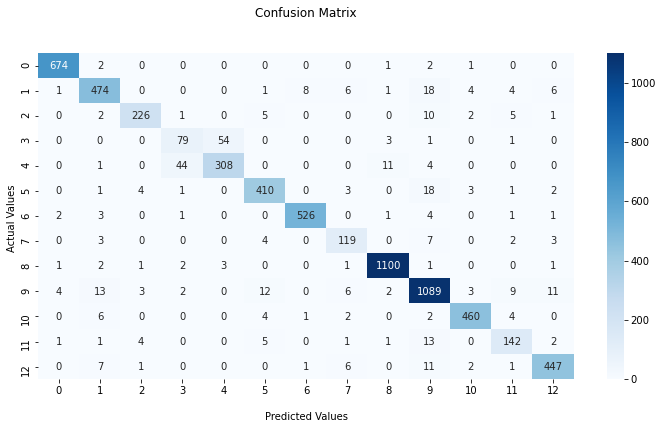

In [22]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predictions)

# Plot the matrix
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Results <a class="anchor" id="results"></a>

Below, you can see how the model performs on the unlabeled data. I add the probabilities for the dominant classes predicted by the model to a pandas dataframe. Then we can easily filter less probable and highly probable categories. This is beneficial because then we can manually confirm or correct misclassified products with low probabilities. Nonetheless, it is not guaranteed that high probability classes may not be misclassified.

In [24]:
target = pd.read_csv('./data/target.csv')
target.head()

,product,category
0,Sport Kókusz Duó,NaN
1,Milsani Biactiv joghurt L. casei,NaN
2,Milfina - desira Alpesi vagy márkázott vaj,NaN
3,Pick Sertéskaraj,NaN
4,Nature's gold Hullámos burgonya,NaN


In [25]:
# Fit the data and then return the matrix
bow_data = tfidf_transformer.transform(target['product'].values)

# predict categories
predictions = calibrator_clf.predict(bow_data)
probabilities = [max(x) for x in calibrator_clf.predict_proba(bow_data)]
pred_df = pd.DataFrame(columns=['product', 'category', 'probability'])
pred_df['product'] = target['product'].values
pred_df['category'] = predictions
pred_df['probability'] = probabilities

In [35]:
# nr. of values in predicted categories
pred_df['category'].value_counts()

Tartós élelmiszerek                232
Tejtermék                          197
Édesség, csokoládé, nasi           147
Hús, hal, felvágott                138
Alkohol                            102
Italok                              78
Egészséges életmód                  73
Pékáru                              68
Fagyasztott élelmiszer              43
Zöldség, gyümölcs                   40
Háztartási-, vegyi- és papíráru     38
Szépségápolás                       28
Háztartás                            8
Name: category, dtype: int64

Let's examine the number of predictions with high probability. Here I set high probability as 0.8 as a heuristic. We can see that ~77% of all predictions have high probabilities.

In [34]:
# set a heuristic for high probability (here 0.8)
high_prob = pred_df.loc[pred_df.probability > 0.8]
print(f"""
Total nr. of observations: {len(pred_df)}
Total nr. of observations with high probability classes: {len(high_prob)} ({len(high_prob)/len(pred_df)*100:.2f}% of all)
""")


Total nr. of observations: 1192
Total nr. of observations with high probability classes: 917 (76.93% of all)



Let's further check the worst predictions to find patterns where the model is making mistakes.\
By taking a look at the 10 worst predictions, the model has a hard time correctly classifying pastry, meat and alcohol.

In [37]:
pred_df.sort_values(by=['probability']).head(10)

,product,category,probability
141,Azon melegében Mini-burek,"Hús, hal, felvágott",0.234304
102,Goldland Mini fasírtgolyók,"Hús, hal, felvágott",0.234304
832,Forralt bor,"Háztartási-, vegyi- és papíráru",0.332476
364,Villány Günzer borok,Alkohol,0.350555
759,Milfina - new lifestyle Tejszínhabspray,Szépségápolás,0.352234
1120,Mátra Pinot Grigio Blush,Tartós élelmiszerek,0.353050
459,Balatonboglár Kristinus,Tartós élelmiszerek,0.371063
1191,Illatosított teamécses,Szépségápolás,0.371203
877,Nature's gold Fehér bab,Szépségápolás,0.378725
763,Azon melegében Mini sajtos-tejfölös lángos,"Édesség, csokoládé, nasi",0.383755


## Discussion <a class="anchor" id="discussion"></a>

With a simple data pipeline using TF-IDF vectorization, stratified samples and grid searching for hyperparameters for linear SVM model I achieved 89.5% balanced accuracy across 12 categories for products. This allows for fast categorization of such products that come from uncategorized sources. 

Nonetheless, it is important to mention that, as all models, this one is not perfect either and there is room for improvement. First of all, it is possible that implementing stemming or lemmatization can improve the model. This is because stemming/lemmatization keeps only the core of a term, removing e.g. the plural form.\
Moreover, one could apply unsupervised learning, for example, topic modeling, to create the categories that way.\
Lastly, the holy grail of all analytical approaches: get more labeled data to train the model. This will result in more accurate results, especially for classes with low value counts.